# Heavylight example notebook

In [1]:
from heavylight import Model

Define the model as a class - note that it doesn't need to be defined in terms of `t` for time, but this is fairly standard

In [2]:
class Annuity(Model):
    def t(self, t):
        return t

    def expected_claim(self, t):
        return self.number_alive(t) * self.data["annuity_per_period"]

    def number_alive(self, t):
        if t == 0:
            return self.data["initial_policies"]
        else:
            return self.number_alive(t - 1) - self.deaths(t - 1)
    
    def deaths(self, t):
        return self.number_alive(t) * self.mortality_rate(t)

    def mortality_rate(self, t):
        return self.basis["q_x"](t)

Define the data for the model, as a python dictionary (can use any storage object)

In [3]:
policy_data = {
    "initial_policies": 10,
    "annuity_per_period": 55,
}

Rather than using a table of mortality rates, we could define a function

In [4]:
def q_x(t):
    return 0.02*2.64**(0.04 * (t + 30)) + 0.002

Store this function in a basis dictionary so we can pass into the model

In [5]:
basis = {
    "q_x": q_x,
}

Create an instance of the model, passing in the data and basis.

In [6]:
model = Annuity(data = policy_data,
                basis = basis,
                do_run = True,
                proj_len = 40,
                )

/Users/lewisfogden/Dev/heavylight/src/heavylight/heavylight.py:78: UserWarning: Warning: `do_run` will be removed in a future version, use `proj_len` to control projection
  warnings.warn("Warning: `do_run` will be removed in a future version, use `proj_len` to control projection")


We can look-up individual results of the model directly

In [7]:
model.expected_claim(5)

379.7484060121289

Pull all single parameter functions into a dataframe

In [8]:
model_cashflows = model.df
model_cashflows.head()

,t,deaths,expected_claim,mortality_rate,number_alive
0,0,0.661143,550.000000,0.066114,10.000000
1,1,0.641139,513.637151,0.068653,9.338857
2,2,0.620078,478.374486,0.071292,8.697718
3,3,0.598033,444.270217,0.074036,8.077640
4,4,0.575091,411.378405,0.076888,7.479607


In [9]:
print(model_cashflows.head(5).to_markdown())

|    |   t |   deaths |   expected_claim |   mortality_rate |   number_alive |
|---:|----:|---------:|-----------------:|-----------------:|---------------:|
|  0 |   0 | 0.661143 |          550     |        0.0661143 |       10       |
|  1 |   1 | 0.641139 |          513.637 |        0.0686529 |        9.33886 |
|  2 |   2 | 0.620078 |          478.374 |        0.071292  |        8.69772 |
|  3 |   3 | 0.598033 |          444.27  |        0.0740356 |        8.07764 |
|  4 |   4 | 0.575091 |          411.378 |        0.0768878 |        7.47961 |


Plot the key output

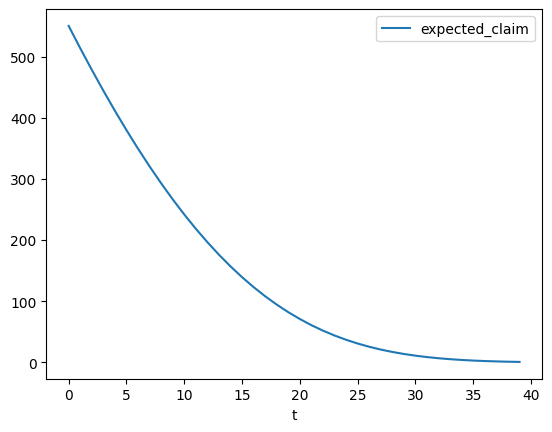

In [10]:
model_cashflows.plot(x="t", y="expected_claim");

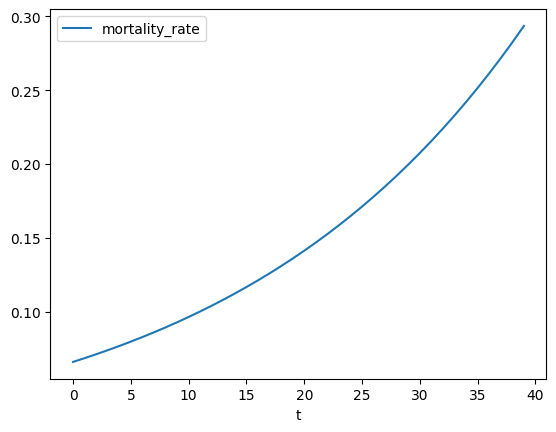

In [11]:
model_cashflows.plot(x="t", y="mortality_rate");

In [12]:
## Calculate the present value

In [13]:
def npv(cashflows, rate):
    return sum(cashflow / ((1 + rate) ** t) for t, cashflow in enumerate(cashflows, 1))

In [14]:
npv(model_cashflows["expected_claim"], 0.04)

4364.808437169173

Quick check that the NPV formula is sensible

In [15]:
npv(model_cashflows["expected_claim"], 0)

5963.772020370224

In [16]:
model_cashflows.expected_claim.sum()

5963.772020370224